In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [54]:
"""
AdaptiveForecaster - A flexible class for time series forecasting with sktime
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union, Dict, Any, Optional, Tuple

from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV, 
    temporal_train_test_split
)
from sktime.split import (
    ExpandingWindowSplitter, 
    SlidingWindowSplitter,
    TemporalTrainTestSplitter
)
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError, 
    MeanSquaredError,
    MeanAbsoluteError
)

# Import our models factory
from models import get_forecaster, ALGORITHM_MAP

class AdaptiveForecaster:
    """
    A flexible class for time series forecasting that allows users to:
    - Choose from various forecasting algorithms
    - Apply different cross-validation strategies
    - Select performance metrics
    - Fit, predict and evaluate models
    - Visualize results
    
    This class wraps around the forecaster factory in models.py
    """
    
    def __init__(
        self,
        algorithm: str = 'arima',
        seasonal_period: int = 12,
        fh: Union[int, List[int]] = 3,
        cv_strategy: str = 'expanding',
        cv_window_length: int = 12,
        cv_step_length: int = 1,
        cv_initial_window: int = 24,
        test_size: float = 0.2,
        metric: str = 'rmse',
        n_jobs: int = -1,
        verbose: int = 1
    ):
        """
        Initialize the AdaptiveForecaster.
        
        Parameters
        ----------
        algorithm : str, default='arima'
            Name of the forecasting algorithm to use. Must be a key in ALGORITHM_MAP.
        seasonal_period : int, default=12
            The seasonal period of the time series.
        fh : int or list of ints, default=3
            The forecast horizon.
        cv_strategy : str, default='expanding'
            The cross-validation strategy to use. 
            Options: 'expanding', 'sliding', 'temporal'.
        cv_window_length : int, default=12
            The length of the window for cross-validation.
        cv_step_length : int, default=1
            The step length for sliding and expanding window cross-validation.
        cv_initial_window : int, default=24
            The initial window size for expanding window cross-validation.
        test_size : float, default=0.2
            The proportion of the dataset to include in the test split when using
            temporal_train_test_split.
        metric : str, default='rmse'
            The performance metric to use. 
            Options: 'rmse', 'mse', 'mae', 'mape'.
        n_jobs : int, default=-1
            The number of jobs to run in parallel.
        verbose : int, default=1
            The verbosity level.
        """
        # Validate algorithm
        if algorithm not in ALGORITHM_MAP:
            raise ValueError(f"Unknown algorithm: {algorithm}. Available: {list(ALGORITHM_MAP.keys())}")
        
        self.algorithm = algorithm
        self.seasonal_period = seasonal_period
        self.fh = fh
        self.cv_strategy = cv_strategy
        self.cv_window_length = cv_window_length
        self.cv_step_length = cv_step_length
        self.cv_initial_window = cv_initial_window
        self.test_size = test_size
        self.metric_name = metric
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        # Initialize attributes that will be set later
        self.forecaster = None
        self.cv_splitter = None
        self.grid_search = None
        self.best_params = None
        self.best_score = None
        self.predictions = None
        self.prediction_intervals = None
        self.train_y = None
        self.test_y = None
        self.metric_func = None
        self.test_score = None
        
        # Set up the forecaster and cross-validation
        self._setup_forecaster()
        self._setup_metric()
    
    def _setup_forecaster(self):
        """Set up the forecaster using models.py factory function."""
        self.forecaster = get_forecaster(
            algorithm=self.algorithm,
            seasonal_period=self.seasonal_period
        )
    
    def _setup_metric(self):
        """Set up the performance metric function."""
        self.metrics_map = {
            'rmse': MeanSquaredError(square_root=True),
            'mse': MeanSquaredError(square_root=False),
            'mae': MeanAbsoluteError(),
            'mape': MeanAbsolutePercentageError()
        }
        
        if self.metric_name not in self.metrics_map:
            raise ValueError(f"Unknown metric: {self.metric_name}. Available: {list(self.metrics_map.keys())}")
        
        self.metric_func = self.metrics_map[self.metric_name]
    
    def _setup_cv_splitter(self, y=None):
        """Set up the cross-validation splitter based on cv_strategy."""
        if self.cv_strategy == 'expanding':
            self.cv_splitter = ExpandingWindowSplitter(
                initial_window=self.cv_initial_window,
                step_length=self.cv_step_length,
                fh=self.fh
            )
        elif self.cv_strategy == 'sliding':
            self.cv_splitter = SlidingWindowSplitter(
                window_length=self.cv_window_length,
                step_length=self.cv_step_length,
                fh=self.fh
            )
        elif self.cv_strategy == 'temporal':
            if y is None:
                raise ValueError("For temporal CV, y must be provided at initialization")
            self.cv_splitter = TemporalTrainTestSplitter(
                test_size=self.test_size
            )
        else:
            raise ValueError(f"Unknown CV strategy: {self.cv_strategy}. "
                             f"Available: ['expanding', 'sliding', 'temporal']")
    
    def setup_grid_search(self, y=None, param_grid=None):
        """
        Set up the grid search cross-validation.
        
        Parameters
        ----------
        y : pd.Series, optional
            The time series data. Required for temporal CV.
        param_grid : dict, optional
            The parameter grid for grid search. If None, uses the default from the forecaster.
        """
        self._setup_cv_splitter(y)
        
        if param_grid is None:
            param_grid = self.forecaster.get_param_grid()
        
        self.grid_search = ForecastingGridSearchCV(
            forecaster=self.forecaster.permuted,
            param_grid=param_grid,
            cv=self.cv_splitter,
            scoring=self.metric_func,
            n_jobs=self.n_jobs,
            verbose=self.verbose
        )
        
        return self
    
    def split_data(self, y, test_size=None):
        """
        Split the data into training and test sets.
        
        Parameters
        ----------
        y : pd.Series
            The time series data.
        test_size : float, optional
            The proportion of the dataset to include in the test split.
            If None, uses the value from initialization.
        
        Returns
        -------
        train_y, test_y : pd.Series
            The training and test data.
        """
        if test_size is None:
            test_size = self.test_size
        
        self.train_y, self.test_y = temporal_train_test_split(y, test_size=test_size)
        return self.train_y, self.test_y
    
    def fit(self, y, X=None, fh=None, use_test_set=False):
        """
        Fit the forecaster to the training data.
        
        Parameters
        ----------
        y : pd.Series
            The time series data.
        X : pd.DataFrame, optional
            Exogenous variables.
        fh : int or list of ints, optional
            The forecast horizon. If None, uses the value from initialization.
        use_test_set : bool, default=False
            Whether to split the data into train/test sets for final evaluation.
            If True, y is split internally and only the training portion is used for fitting.
        
        Returns
        -------
        self : AdaptiveForecaster
            The fitted forecaster.
        """
        if fh is not None:
            self.fh = fh
        
        # Handle train/test split if requested
        if use_test_set and self.train_y is None:
            print("Splitting data into train/test sets...")
            self.train_y, self.test_y = self.split_data(y)
            # Use training data for fitting
            y_to_fit = self.train_y
        else:
            # Use all data for fitting
            y_to_fit = y
        
        if self.grid_search is None:
            self.setup_grid_search(y_to_fit)
        
        print(f"Fitting {self.algorithm} forecaster with {self.cv_strategy} cross-validation...")
        self.grid_search.fit(y_to_fit, X=X, fh=self.fh)
        
        self.best_params = self.grid_search.best_params_
        self.best_score = self.grid_search.best_score_
        
        return self
    
    def predict(self, fh=None, X=None, return_pred_int=False, coverage=[0.95]):
        """
        Make predictions with the fitted forecaster.
        
        Parameters
        ----------
        fh : int or list of ints, optional
            The forecast horizon. If None, uses the value from initialization.
        X : pd.DataFrame, optional
            Exogenous variables.
        return_pred_int : bool, default=False
            Whether to return prediction intervals.
        coverage : list of float, default=[0.95]
            The coverage of prediction intervals.
        
        Returns
        -------
        predictions : pd.Series
            The point forecasts.
        """
        if self.grid_search is None or not hasattr(self.grid_search, 'best_forecaster_'):
            raise ValueError("Forecaster has not been fitted yet. Call fit() first.")
        
        if fh is None:
            fh = self.fh
        
        print("Making predictions...")
        self.predictions = self.grid_search.best_forecaster_.predict(fh, X=X)
        
        if return_pred_int:
            try:
                self.prediction_intervals = self.grid_search.best_forecaster_.predict_interval(
                    fh=list(range(1, fh + 1)), X=X, coverage=coverage
                )
            except Exception as e:
                print(f"Warning: Could not compute prediction intervals: {e}")
                self.prediction_intervals = None
        
        return self.predictions
    
    def evaluate(self, y_true=None, in_sample=False, metrics=None):
        """
        Evaluate the forecaster on test data or in-sample using multiple metrics.
        
        Parameters
        ----------
        y_true : pd.Series, optional
            The true values to compare against. If None, uses self.test_y or the training data.
        in_sample : bool, default=False
            Whether to evaluate on the training data (in-sample) instead of test data.
            If True and y_true is None, will use the training data.
        metrics : list of str, optional
            List of metric names to compute. If None, computes all available metrics.
            Available: 'rmse', 'mse', 'mae', 'mape'
        
        Returns
        -------
        scores : dict
            Dictionary with metric names as keys and scores as values.
        """
        if self.predictions is None:
            raise ValueError("No predictions available. Call predict() first.")
        
        if y_true is None:
            if in_sample:
                if self.train_y is not None:
                    y_true = self.train_y
                else:
                    raise ValueError("No training data available. Provide y_true or call split_data() first.")
            else:
                if self.test_y is not None:
                    y_true = self.test_y
                else:
                    raise ValueError("No test data available. Provide y_true, call split_data(), "
                                   "or set in_sample=True to evaluate on training data.")
        
        # Align indices for evaluation
        # Only use the indices that appear in both series
        common_indices = y_true.index.intersection(self.predictions.index)
        if len(common_indices) == 0:
            raise ValueError("No common indices between true values and predictions")
        
        y_true_aligned = y_true.loc[common_indices]
        predictions_aligned = self.predictions.loc[common_indices]
        
        # Determine which metrics to compute
        if metrics is None:
            metrics_to_compute = list(self.metrics_map.keys())
        else:
            invalid_metrics = [m for m in metrics if m not in self.metrics_map]
            if invalid_metrics:
                raise ValueError(f"Unknown metrics: {invalid_metrics}. Available: {list(self.metrics_map.keys())}")
            metrics_to_compute = metrics
        
        # Compute all requested metrics
        scores = {}
        for metric_name in metrics_to_compute:
            metric_func = self.metrics_map[metric_name]
            scores[metric_name] = metric_func(y_true_aligned, predictions_aligned)
        
        # Store the main metric score
        self.test_score = scores[self.metric_name]
        
        # Print results
        eval_type = "In-sample" if in_sample else "Test"
        print(f"\n{eval_type} Performance Metrics:")
        print("-" * 30)
        for metric_name, score in scores.items():
            print(f"{metric_name.upper()}: {score:.4f}")
        
        return scores
    
    def plot_forecasts(self, y=None, title=None, figsize=(15, 7), include_intervals=True):
        """
        Plot the time series, forecasts, and prediction intervals.
        
        Parameters
        ----------
        y : pd.Series, optional
            The full time series data. If None, uses the train and test data.
        title : str, optional
            The title of the plot.
        figsize : tuple, default=(15, 7)
            The figure size.
        include_intervals : bool, default=True
            Whether to include prediction intervals in the plot.
        
        Returns
        -------
        fig : matplotlib.figure.Figure
            The figure object.
        """
        if self.predictions is None:
            raise ValueError("No predictions available. Call predict() first.")
        
        plt.figure(figsize=figsize)
        
        # Plot historical data
        if y is not None:
            plt.plot(y.index, y, 'k-', label='Historical Data')
        else:
            if self.train_y is not None:
                plt.plot(self.train_y.index, self.train_y, 'k-', label='Training Data')
            if self.test_y is not None:
                plt.plot(self.test_y.index, self.test_y, 'b-', label='Test Data')
        
        # Plot predictions
        plt.plot(self.predictions.index, self.predictions, 'r-', 
                 label=f'{self.algorithm.capitalize()} Forecast')
        
        # Plot prediction intervals if available
        if include_intervals and self.prediction_intervals is not None:
            for coverage in self.prediction_intervals.index.get_level_values(0).unique():
                lower = self.prediction_intervals.loc[coverage]["lower"]
                upper = self.prediction_intervals.loc[coverage]["upper"]
                plt.fill_between(
                    lower.index, lower, upper, alpha=0.2, color='r',
                    label=f"{int(coverage*100)}% Prediction Interval"
                )
        
        # Set title and labels
        if title is None:
            title = f"{self.algorithm.capitalize()} Forecast with {self.cv_strategy.capitalize()} CV"
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        
        return plt.gcf()
    """
     Extension to AdaptiveForecaster class with refit_on_full_data method
    """

    def forecast_future(self, y, future_horizon=12):
        """
        Refit the model on the full dataset using the best parameters
        found during grid search, and generate future predictions.
        
        Parameters
        ----------
        y : pd.Series
            The full time series dataset
        future_horizon : int, default=12
            Number of periods to forecast into the future
            
        Returns
        -------
        future_predictions : pd.Series
            Forecasts for the future periods
        """
        if not hasattr(self, 'best_params') or self.best_params is None:
            raise ValueError("The forecaster must be fitted before calling refit_on_full_data")
        
        # Store the original forecast horizon
        original_fh = self.fh
        
        # Set the forecast horizon for future predictions
        self.fh = list(range(1, future_horizon + 1))
        
        print(f"Refitting {self.algorithm} on full dataset with best parameters...")
        
        # Create a new grid search with only the best parameters
        # (wrap each parameter value in a list to match param_grid format)
        best_param_grid = {key: [value] for key, value in self.best_params.items()}
        
        # Save old grid search to restore later if needed
        old_grid_search = self.grid_search if hasattr(self, 'grid_search') else None
        
        # Set up a new cross-validation splitter
        self._setup_cv_splitter(y)
        
        # Create a grid search with the single set of parameters
        # This effectively just fits once with the best parameters
        from sktime.forecasting.model_selection import ForecastingGridSearchCV
        
        self.grid_search = ForecastingGridSearchCV(
            forecaster=self.forecaster.permuted,
            param_grid=best_param_grid,
            cv=self.cv_splitter,
            scoring=self.metric_func,
            n_jobs=self.n_jobs,
            verbose=0
        )
        
        # Fit on full dataset
        self.grid_search.fit(y, fh=self.fh)
        
        # Generate future predictions
        print(f"Generating future predictions for {future_horizon} periods...")
        future_predictions = self.predict()
        
        # For clarity, we'll mark that this forecaster is now fitted on full data
        self.is_fitted_on_full_data = True
        
        # Restore original forecast horizon
        self.fh = original_fh
        
        return future_predictions
    
    def summary(self, include_metrics=None):
        """
        Print a summary of the forecasting results.
        
        Parameters
        ----------
        include_metrics : list of str, optional
            List of metric names to include in summary. If None, includes the main metric.
            
        Returns
        -------
        summary_dict : dict
            A dictionary containing the summary information.
        """
        if self.grid_search is None or not hasattr(self.grid_search, 'best_forecaster_'):
            raise ValueError("Forecaster has not been fitted yet. Call fit() first.")
        
        # Compute additional metrics if requested
        all_metrics = {}
        if include_metrics and self.test_y is not None and self.predictions is not None:
            all_metrics = self.evaluate(metrics=include_metrics)
        
        summary_dict = {
            "Algorithm": self.algorithm,
            "CV Strategy": self.cv_strategy,
            "Primary Metric": self.metric_name.upper(),
            "CV Score": self.best_score,
            "Test Score": self.test_score if self.test_score is not None else "Not evaluated",
            "Best Parameters": self.best_params,
        }
        
        # Add other metrics if available
        for metric, score in all_metrics.items():
            if metric != self.metric_name:  # Skip primary metric as it's already included
                summary_dict[f"{metric.upper()} Score"] = score
        
        print("\n" + "="*50)
        print(f"ADAPTIVE FORECASTER SUMMARY")
        print("="*50)
        
        # Print algorithm and strategy first
        print(f"Algorithm: {summary_dict['Algorithm']}")
        print(f"CV Strategy: {summary_dict['CV Strategy']}")
        
        # Print metrics section
        print("\nMetrics:")
        print(f"  Primary ({summary_dict['Primary Metric']})")
        print(f"    CV: {summary_dict['CV Score']:.4f}")
        print(f"    Test: {summary_dict['Test Score'] if isinstance(summary_dict['Test Score'], str) else summary_dict['Test Score']:.4f}")
        
        # Print additional metrics if available
        for k, v in summary_dict.items():
            if k.endswith(' Score') and k not in ['CV Score', 'Test Score']:
                print(f"  {k}: {v:.4f}")
        
        # Print best parameters
        print("\nBest Parameters:")
        for param, value in summary_dict['Best Parameters'].items():
            print(f"  {param}: {value}")
        
        print("="*50 + "\n")
        
        return summary_dict


In [4]:
"""
Example showing how to evaluate forecasts with multiple metrics
"""
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datasets import load_airline

#from adaptive_forecaster import AdaptiveForecaster

# Load example data
print("Loading airline passengers dataset...")
y = load_airline()

# Create forecaster with RMSE as the primary optimization metric
forecaster = AdaptiveForecaster(
    algorithm='exp_smoothing',
    seasonal_period=12,
    fh=6,
    cv_strategy='expanding',
    cv_initial_window=80,
    test_size=0.2,
    metric='rmse'  # Primary metric for optimization
)

# Split data, fit model, and make predictions
train_y, test_y = forecaster.split_data(y)

forecaster.fit(train_y)
"""
forecaster.predict()

# Evaluate with multiple metrics
print("\n=== Evaluating with Multiple Metrics ===")
all_metrics = forecaster.evaluate(metrics=['rmse', 'mse', 'mae', 'mape'])

print("\nNote that the model was optimized for RMSE during cross-validation,")
print("but we can evaluate its performance using multiple metrics.")

# Create a comprehensive summary that includes all metrics
print("\n=== Comprehensive Model Summary ===")
summary = forecaster.summary(include_metrics=['rmse', 'mse', 'mae', 'mape'])

# Plot the forecasts
fig = forecaster.plot_forecasts(y)
plt.tight_layout()
"""

Loading airline passengers dataset...
Fitting exp_smoothing forecaster with expanding cross-validation...
Fitting 30 folds for each of 144 candidates, totalling 4320 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster Permute failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=80.
                The score will be set to nan.
                Failed forecaster with parameters: Permute(estimator=TransformedTargetForecaster(steps=[(

'\nforecaster.predict()\n\n# Evaluate with multiple metrics\nprint("\n=== Evaluating with Multiple Metrics ===")\nall_metrics = forecaster.evaluate(metrics=[\'rmse\', \'mse\', \'mae\', \'mape\'])\n\nprint("\nNote that the model was optimized for RMSE during cross-validation,")\nprint("but we can evaluate its performance using multiple metrics.")\n\n# Create a comprehensive summary that includes all metrics\nprint("\n=== Comprehensive Model Summary ===")\nsummary = forecaster.summary(include_metrics=[\'rmse\', \'mse\', \'mae\', \'mape\'])\n\n# Plot the forecasts\nfig = forecaster.plot_forecasts(y)\nplt.tight_layout()\n'

In [ ]:
forecaster.predict()
print("\n=== Evaluating with Multiple Metrics ===")
all_metrics = forecaster.evaluate(metrics=['rmse', 'mse', 'mae', 'mape'])

print("\nNote that the model was optimized for RMSE during cross-validation,")
print("but we can evaluate its performance using multiple metrics.")

# Create a comprehensive summary that includes all metrics
print("\n=== Comprehensive Model Summary ===")
summary = forecaster.summary(include_metrics=['rmse', 'mse', 'mae', 'mape'])

# Plot the forecasts
fig = forecaster.plot_forecasts(y)
plt.tight_layout()

In [23]:
forecaster.grid_search.best_forecaster_

NameError: name 'forecaster' is not defined

In [6]:
import warnings
import os
from sktime.datasets import load_airline
os.environ['PYTHONWARNINGS'] = 'ignore'
algorithms = ['arima', 'exp_smoothing', 'stats_arima', 'naive']
results = []
y = load_airline()
# Create a DataFrame to store all results
comparison_data = []

for algo in algorithms:
    print(f"\nTesting {algo}...")
    algo_forecaster = AdaptiveForecaster(
        algorithm=algo,
        seasonal_period=12, 
        fh=6,
        cv_strategy='expanding',
        cv_initial_window=80,
        cv_step_length=3,
        metric='rmse',  # All models optimize for RMSE
        verbose=0
    )
    
    try:
        # Split, fit, predict
        train_y, test_y = algo_forecaster.split_data(y)
        algo_forecaster.fit(train_y)
        algo_forecaster.predict()
        
        # Evaluate with all metrics
        metrics = algo_forecaster.evaluate(metrics=['rmse', 'mse', 'mae', 'mape'])
        
        # Add to comparison data
        comparison_data.append({
            'Algorithm': algo,
            'RMSE': metrics['rmse'],
            'MSE': metrics['mse'],
            'MAE': metrics['mae'],
            'MAPE': metrics['mape']
        })
    except Exception as e:
        print(f"Error with {algo}: {e}")

# Create comparison table
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n=== Algorithm Comparison ===")
    print(comparison_df.set_index('Algorithm'))
    
    # Find best algorithm for each metric
    print("\n=== Best Algorithm per Metric ===")
    for metric in ['RMSE', 'MSE', 'MAE', 'MAPE']:
        best_algo = comparison_df.loc[comparison_df[metric].idxmin()]
        print(f"Best for {metric}: {best_algo['Algorithm']} ({best_algo[metric]:.4f})")


Testing arima...
Fitting arima forecaster with expanding cross-validation...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yaeg/Documents/projects/packages/Adaptive_

Making predictions...

Test Performance Metrics:
------------------------------
RMSE: 12.7267
MSE: 161.9690
MAE: 12.7267
MAPE: 0.0354

Testing exp_smoothing...
Fitting exp_smoothing forecaster with expanding cross-validation...
Making predictions...

Test Performance Metrics:
------------------------------
RMSE: 14.4468
MSE: 208.7088
MAE: 14.4468
MAPE: 0.0401

Testing stats_arima...
Fitting stats_arima forecaster with expanding cross-validation...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnin

Making predictions...

Test Performance Metrics:
------------------------------
RMSE: 17.5300
MSE: 307.3016
MAE: 17.5300
MAPE: 0.0487

Testing naive...
Fitting naive forecaster with expanding cross-validation...
Making predictions...

Test Performance Metrics:
------------------------------
RMSE: 10.1629
MSE: 103.2838
MAE: 10.1629
MAPE: 0.0282

=== Algorithm Comparison ===
                    RMSE         MSE        MAE      MAPE
Algorithm                                                
arima          12.726703  161.968964  12.726703  0.035352
exp_smoothing  14.446757  208.708789  14.446757  0.040130
stats_arima    17.530021  307.301632  17.530021  0.048695
naive          10.162866  103.283844  10.162866  0.028230

=== Best Algorithm per Metric ===
Best for RMSE: naive (10.1629)
Best for MSE: naive (103.2838)
Best for MAE: naive (10.1629)
Best for MAPE: naive (0.0282)


In [13]:
cv = ExpandingWindowSplitter(
    initial_window=86,  # 2 years of monthly data
    step_length=3,      # move forward 1 month each time
)
test_grid = {'estimator__deseasonalizer__passthrough': [True],
 'estimator__detrender__passthrough': [False],
 'estimator__forecaster__sp': [12],
 'estimator__forecaster__strategy': ['last'],
 'estimator__forecaster__window_length': [None],
 'estimator__scaler__passthrough': [True]}
dummy = ForecastingGridSearchCV(
            forecaster=algo_forecaster.grid_search.best_forecaster_,
            param_grid=test_grid,
            cv=cv,
            scoring=MeanSquaredError(square_root=True),
            n_jobs=-1
        )

dummy.fit(y)
#algo_forecaster.grid_search.best_forecaster_

/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(initial_window=86,
                                                   step_length=3),
                        forecaster=Permute(estimator=TransformedTargetForecaster(steps=[('detrender',
                                                                                         OptionalPassthrough(transformer=Detrender())),
                                                                                        ('deseasonalizer',
                                                                                         OptionalPassthrough(passthrough=True,
                                                                                                             transformer=Deseasonalizer(sp=12))),
                                                                                        ('scaler',
                                                                                         OptionalPassthrough(passthrough=True,
                                                                                                             trans...
                                                                                        ('forecaster',
                                                                                         NaiveForecaster(sp=12))])),
                        n_jobs=-1,
                        param_grid={'estimator__deseasonalizer__passthrough': [True],
                                    'estimator__detrender__passthrough': [False],
                                    'estimator__forecaster__sp': [12],
                                    'estimator__forecaster__strategy': ['last'],
                                    'estimator__forecaster__window_length': [None],
                                    'estimator__scaler__passthrough': [True]},
                        scoring=MeanSquaredError(square_root=True))

In [16]:
dummy.predict(fh=[1,2,3,4,5,6])

1961-01    448.886207
1961-02    422.886207
1961-03    450.886207
1961-04    492.886207
1961-05    503.886207
1961-06    566.886207
Freq: M, Name: Number of airline passengers, dtype: float64

Loading airline passengers dataset...
Training set: 120 observations (1949-01 - 1958-12)
Test set: 24 observations (1959-01 - 1960-12)

--------------------------------------------------
Testing naive...
--------------------------------------------------
Fitting naive on training data...
Fitting naive forecaster with expanding cross-validation...
Fitting 4 folds for each of 144 candidates, totalling 576 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating test predictions for naive...
Making predictions...
Test Predictions: 1958-08    416.040820
1958-09    408.246260
1958-10    388.199964
1958-11    327.266722
1958-12    377.286976
1959-01    392.564754
1959-02    356.142508
1959-03    413.392508
1959-04    417.674915
1959-05    385.183224
1959-06    443.933224
1959-07    481.650817
1959-08    446.203686
1959-09    438.409126
1959-10    418.362830
1959-11    357.429588
1959-12    407.449842
1960-01    422.727620
1960-02    386.305374
1960-03    443.555374
1960-04    447.837781
1960-05    415.346090
1960-06    474.096090
1960-07    511.813683
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating naive on test set...

Test Performance Metrics:
------------------------------
RMSE: 46.6670
MAPE: 0.0724
MAE: 34.0259
MSE: 2177.8096
Refitting naive on full dataset and generating future predictions...
Refitting naive on full dataset with best parameters...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    416.040820
1958-09    408.246260
1958-10    388.199964
1958-11    327.266722
1958-12    377.286976
1959-01    392.564754
1959-02    356.142508
1959-03    413.392508
1959-04    417.674915
1959-05    385.183224
1959-06    443.933224
1959-07    481.650817
1959-08    446.203686
1959-09    438.409126
1959-10    418.362830
1959-11    357.429588
1959-12    407.449842
1960-01    422.727620
1960-02    386.305374
1960-03    443.555374
1960-04    447.837781
1960-05    415.346090
1960-06    474.096090
1960-07    511.813683
Freq: M, Name: Number of airline passengers, dtype: float64


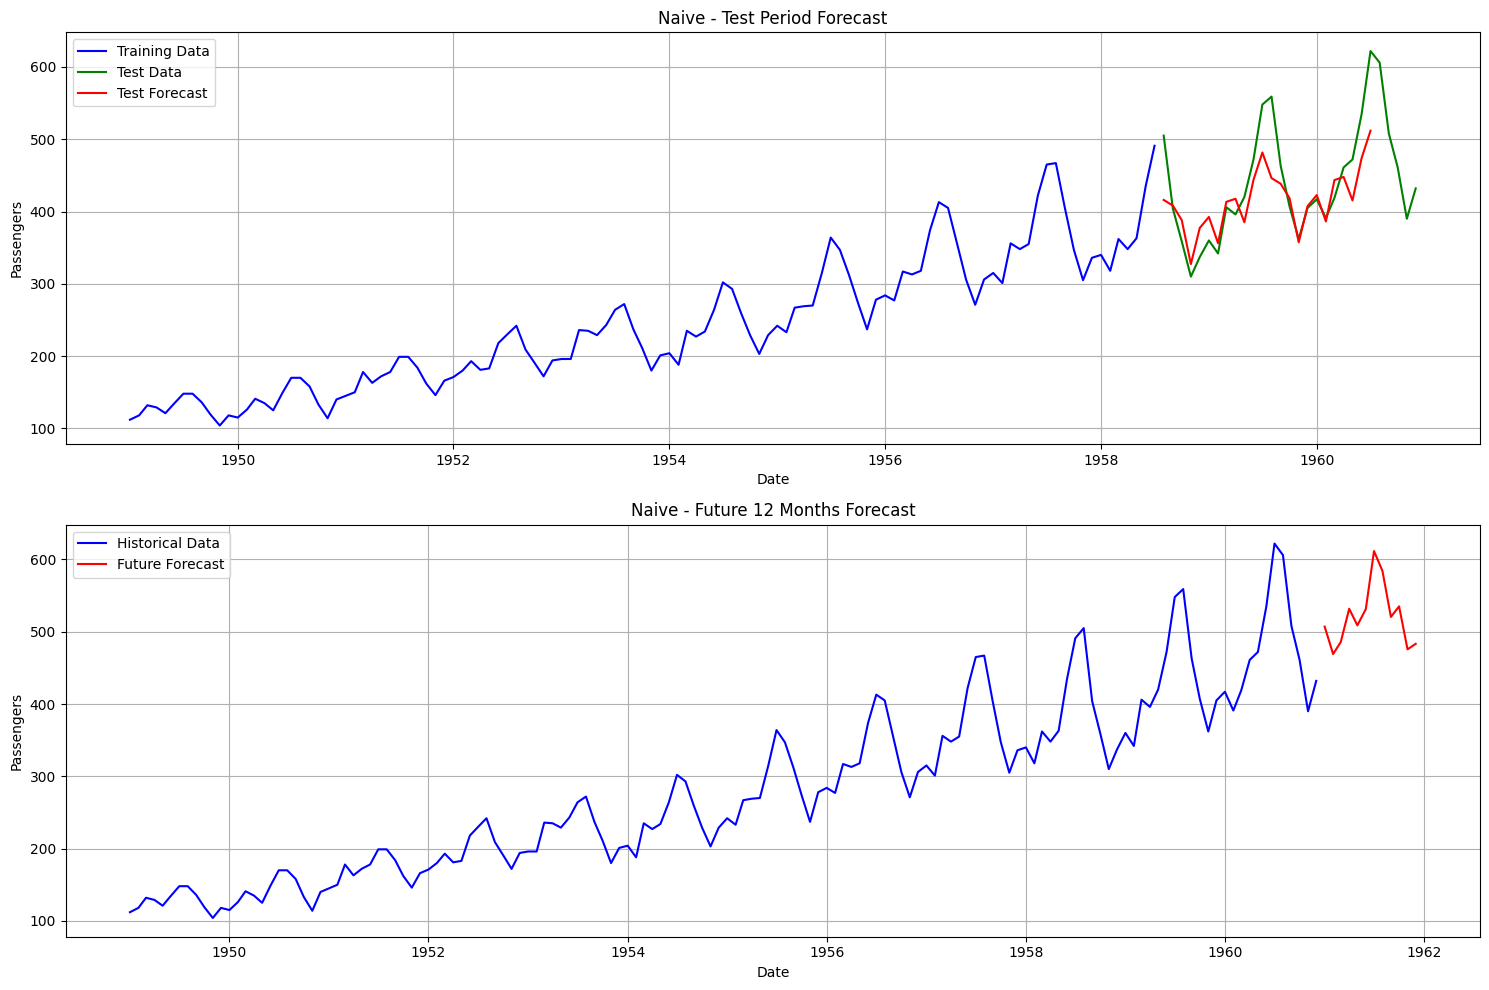


--------------------------------------------------
Testing stats_arima...
--------------------------------------------------
Fitting stats_arima on training data...
Fitting stats_arima forecaster with expanding cross-validation...
Fitting 4 folds for each of 32 candidates, totalling 128 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnin

Generating test predictions for stats_arima...
Making predictions...
Test Predictions: 1958-08    490.258742
1958-09    457.375588
1958-10    422.532285
1958-11    384.681624
1958-12    361.057349
1959-01    351.672631
1959-02    360.103816
1959-03    380.433521
1959-04    407.578777
1959-05    433.674412
1959-06    453.479419
1959-07    463.342546
1959-08    463.110725
1959-09    454.849506
1959-10    442.504713
1959-11    430.317489
1959-12    421.934692
1960-01    419.460772
1960-02    423.251429
1960-03    432.033510
1960-04    443.499694
1960-05    455.013997
1960-06    464.329239
1960-07    470.077322
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating stats_arima on test set...

Test Performance Metrics:
------------------------------
RMSE: 53.0338
MAPE: 0.0884
MAE: 39.1850
MSE: 2812.5816
Refitting stats_arima on full dataset and generating future predictions...
Refitting stats_arima on full dataset with best parameters...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.w

Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    490.258742
1958-09    457.375588
1958-10    422.532285
1958-11    384.681624
1958-12    361.057349
1959-01    351.672631
1959-02    360.103816
1959-03    380.433521
1959-04    407.578777
1959-05    433.674412
1959-06    453.479419
1959-07    463.342546
1959-08    463.110725
1959-09    454.849506
1959-10    442.504713
1959-11    430.317489
1959-12    421.934692
1960-01    419.460772
1960-02    423.251429
1960-03    432.033510
1960-04    443.499694
1960-05    455.013997
1960-06    464.329239
1960-07    470.077322
Freq: M, Name: Number of airline passengers, dtype: float64


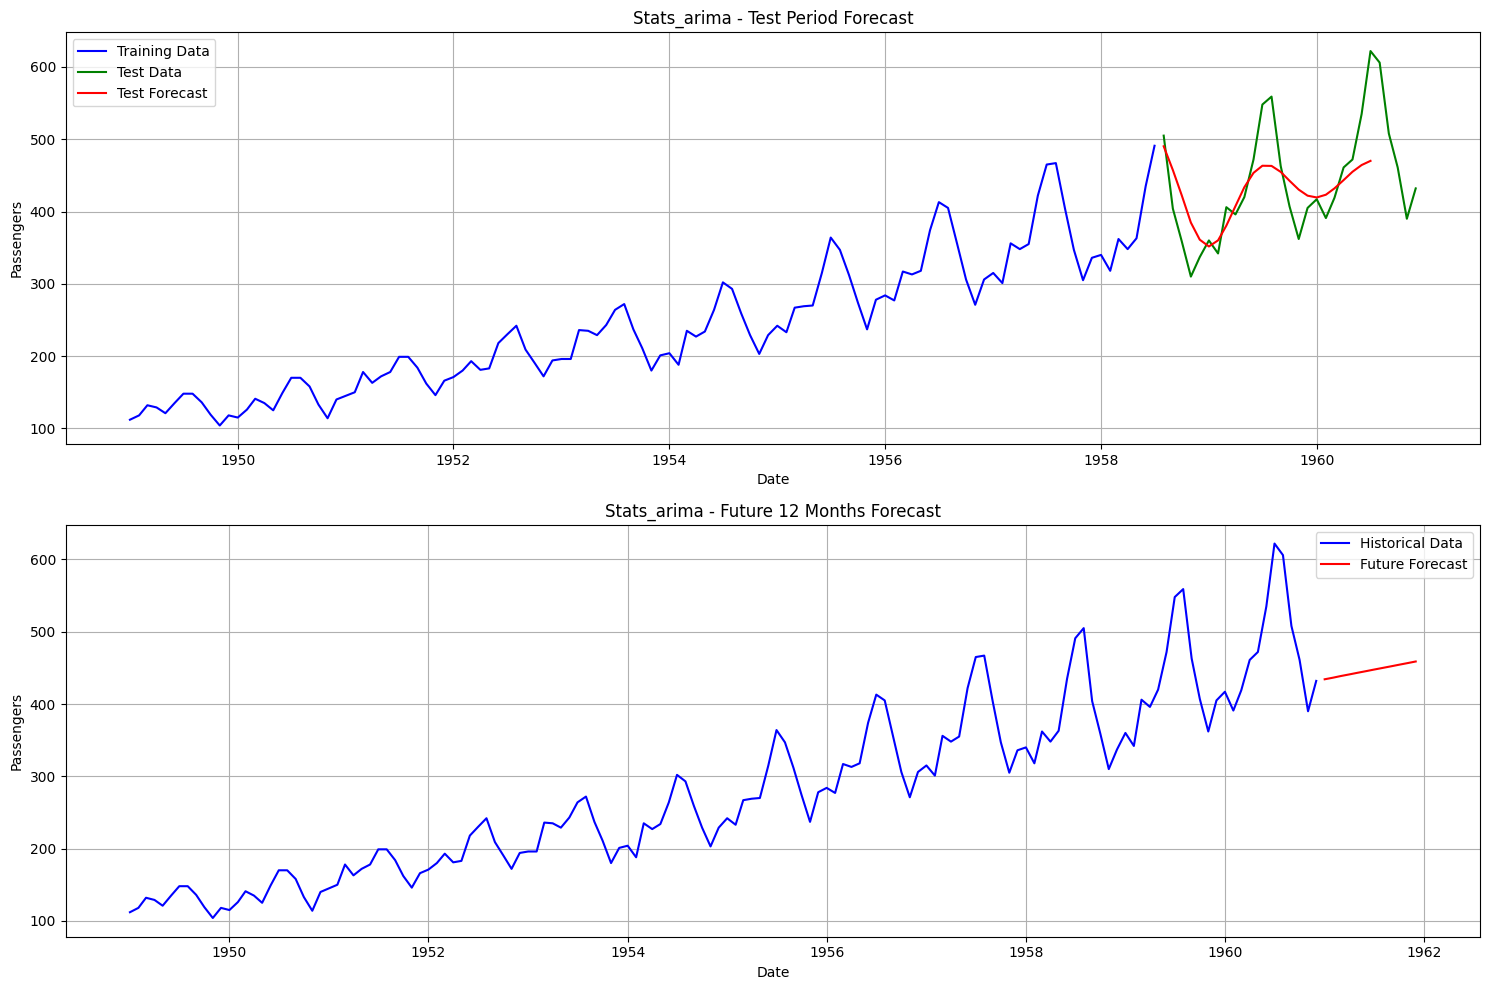


--------------------------------------------------
Testing exp_smoothing...
--------------------------------------------------
Fitting exp_smoothing on training data...
Fitting exp_smoothing forecaster with expanding cross-validation...
Fitting 4 folds for each of 144 candidates, totalling 576 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating test predictions for exp_smoothing...
Making predictions...
Test Predictions: 1958-08    473.699900
1958-09    406.813774
1958-10    349.039484
1958-11    308.211217
1958-12    341.984942
1959-01    349.605835
1959-02    332.055049
1959-03    382.880028
1959-04    374.655298
1959-05    393.092479
1959-06    468.239305
1959-07    509.186676
1959-08    503.710923
1959-09    434.347661
1959-10    374.712863
1959-11    332.901543
1959-12    367.227432
1960-01    375.095642
1960-02    356.495473
1960-03    408.530786
1960-04    400.219800
1960-05    419.774692
1960-06    497.621242
1960-07    539.506889
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating exp_smoothing on test set...

Test Performance Metrics:
------------------------------
RMSE: 35.0182
MAPE: 0.0626
MAE: 28.6662
MSE: 1226.2710
Refitting exp_smoothing on full dataset and generating future predictions...
Refitting exp_smoothing on full dataset with best parameters...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    473.699900
1958-09    406.813774
1958-10    349.039484
1958-11    308.211217
1958-12    341.984942
1959-01    349.605835
1959-02    332.055049
1959-03    382.880028
1959-04    374.655298
1959-05    393.092479
1959-06    468.239305
1959-07    509.186676
1959-08    503.710923
1959-09    434.347661
1959-10    374.712863
1959-11    332.901543
1959-12    367.227432
1960-01    375.095642
1960-02    356.495473
1960-03    408.530786
1960-04    400.219800
1960-05    419.774692
1960-06    497.621242
1960-07    539.506889
Freq: M, Name: Number of airline passengers, dtype: float64


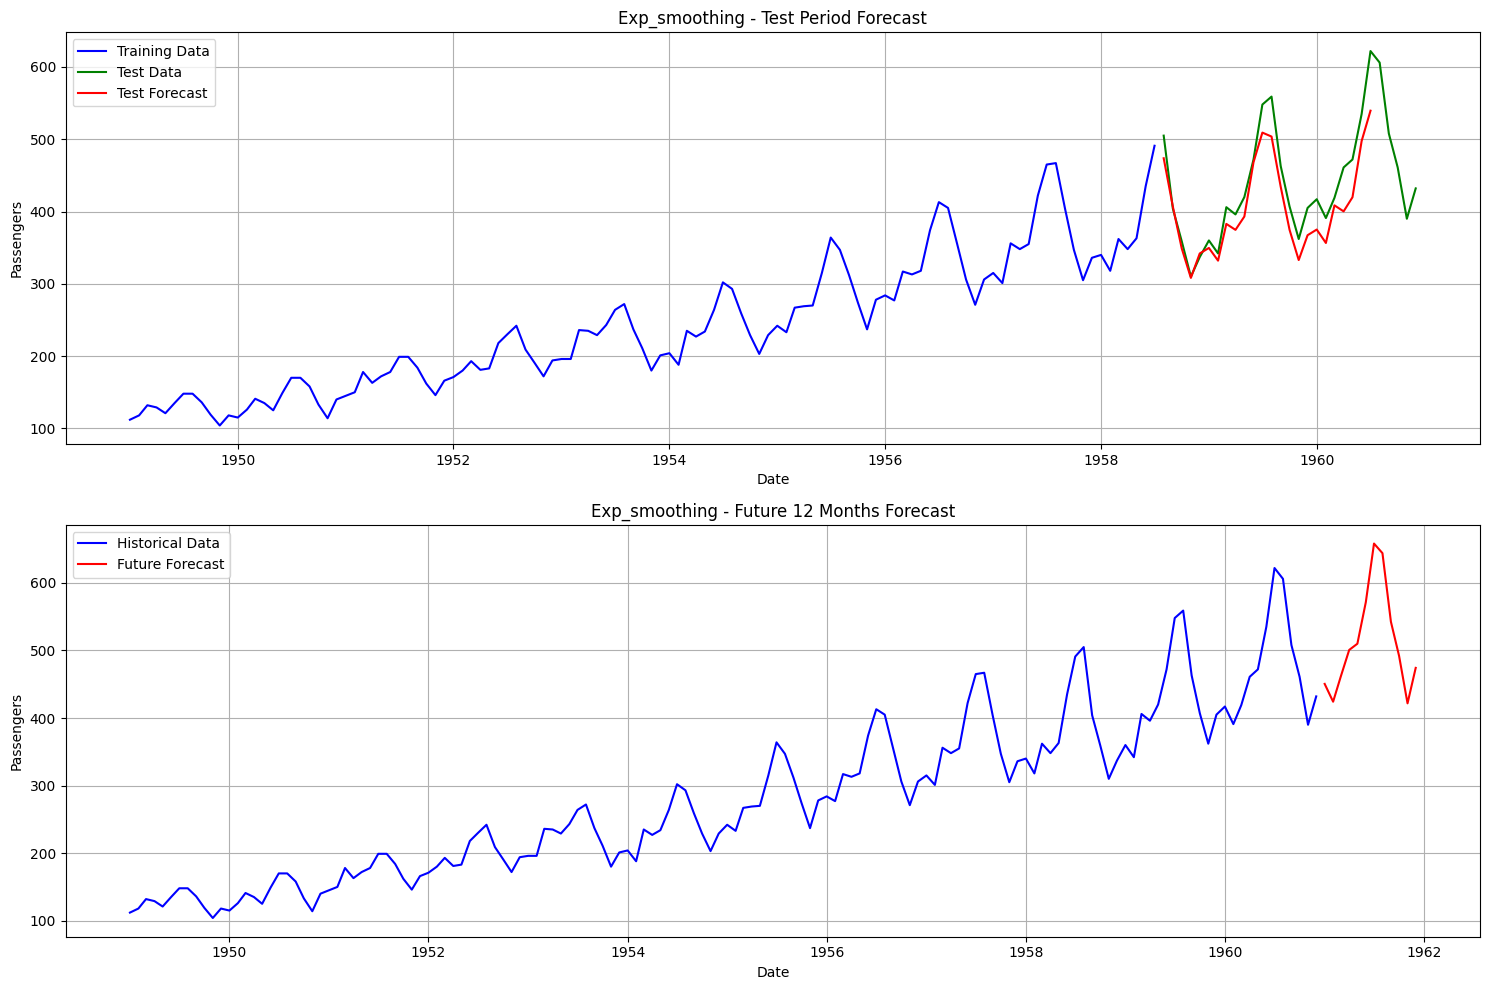


--------------------------------------------------
Testing ets...
--------------------------------------------------
Fitting ets on training data...
Fitting ets forecaster with expanding cross-validation...
Fitting 4 folds for each of 64 candidates, totalling 256 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating test predictions for ets...
Making predictions...
Test Predictions: 1958-08    481.086621
1958-09    441.165622
1958-10    412.393331
1958-11    390.759947
1958-12    424.863822
1959-01    425.751258
1959-02    415.442961
1959-03    458.527784
1959-04    445.830783
1959-05    452.864110
1959-06    499.406278
1959-07    525.980265
1959-08    511.249487
1959-09    471.328488
1959-10    442.556197
1959-11    420.922813
1959-12    455.026688
1960-01    455.914124
1960-02    445.605827
1960-03    488.690650
1960-04    475.993649
1960-05    483.026976
1960-06    529.569144
1960-07    556.143131
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating ets on test set...

Test Performance Metrics:
------------------------------
RMSE: 49.9899
MAPE: 0.1119
MAE: 44.5018
MSE: 2498.9916
Refitting ets on full dataset and generating future predictions...
Refitting ets on full dataset with best parameters...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(


Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    481.086621
1958-09    441.165622
1958-10    412.393331
1958-11    390.759947
1958-12    424.863822
1959-01    425.751258
1959-02    415.442961
1959-03    458.527784
1959-04    445.830783
1959-05    452.864110
1959-06    499.406278
1959-07    525.980265
1959-08    511.249487
1959-09    471.328488
1959-10    442.556197
1959-11    420.922813
1959-12    455.026688
1960-01    455.914124
1960-02    445.605827
1960-03    488.690650
1960-04    475.993649
1960-05    483.026976
1960-06    529.569144
1960-07    556.143131
Freq: M, Name: Number of airline passengers, dtype: float64


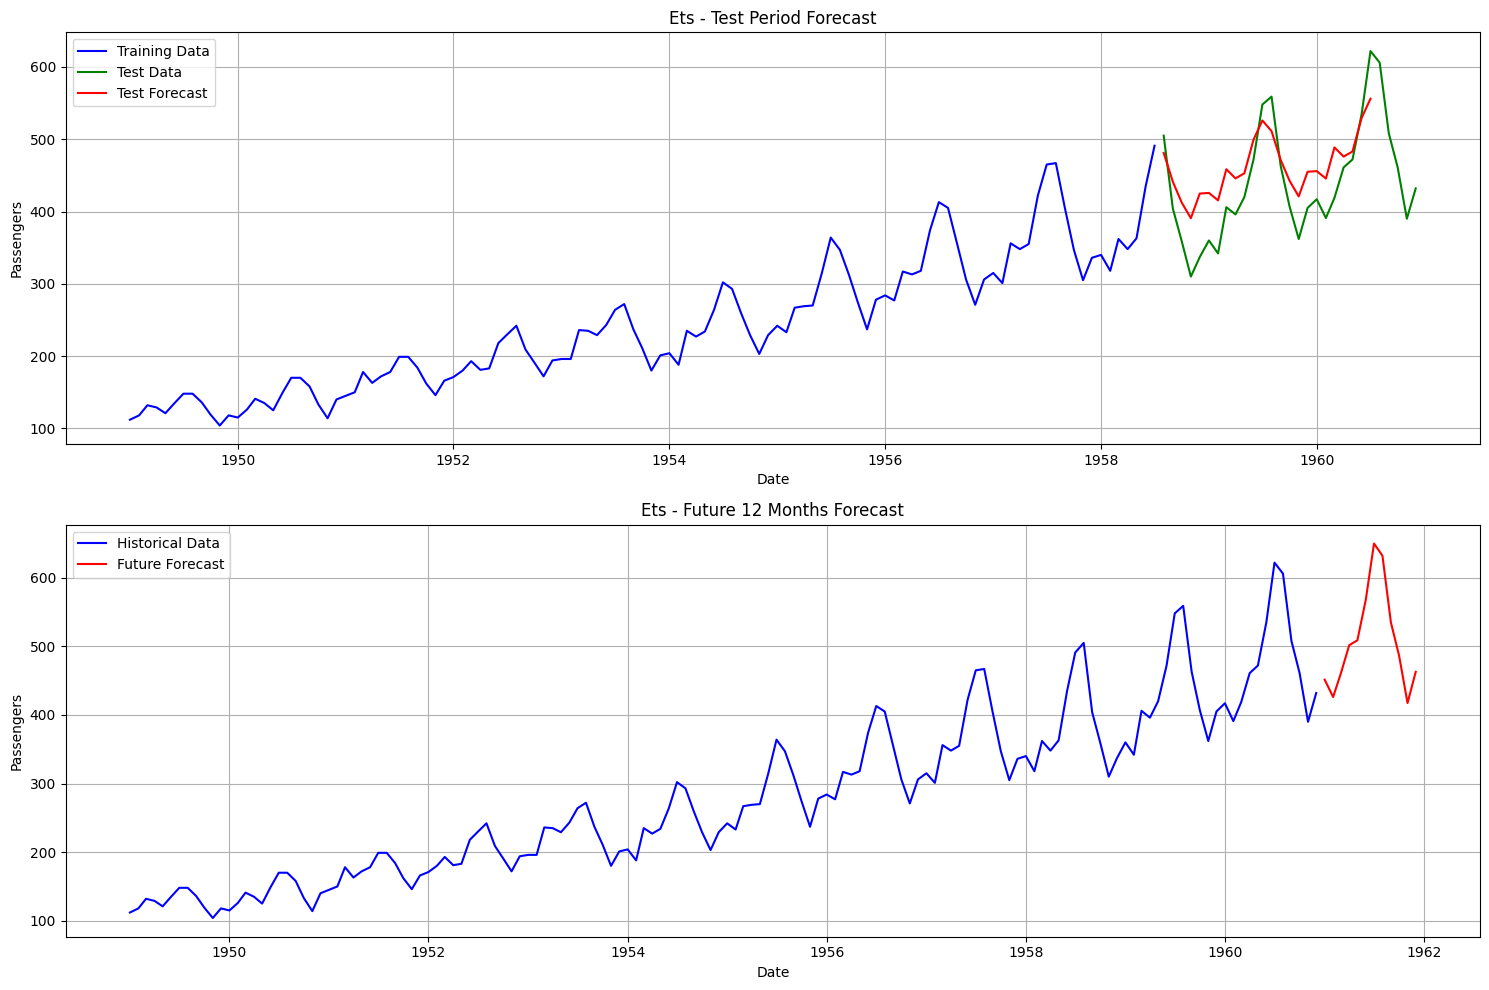


--------------------------------------------------
Testing tbats...
--------------------------------------------------
Fitting tbats on training data...
Fitting tbats forecaster with expanding cross-validation...
Fitting 4 folds for each of 64 candidates, totalling 256 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


Generating test predictions for tbats...
Making predictions...
Test Predictions: 1958-08    485.702785
1958-09    447.595000
1958-10    411.318265
1958-11    404.176907
1958-12    413.248470
1959-01    422.807999
1959-02    435.562581
1959-03    449.292078
1959-04    454.280167
1959-05    461.081080
1959-06    489.527633
1959-07    524.396578
1959-08    525.122270
1959-09    487.014485
1959-10    450.737749
1959-11    443.596391
1959-12    452.667954
1960-01    462.227484
1960-02    474.982065
1960-03    488.711563
1960-04    493.699652
1960-05    500.500565
1960-06    528.947118
1960-07    563.816063
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating tbats on test set...

Test Performance Metrics:
------------------------------
RMSE: 54.7891
MAPE: 0.1246
MAE: 49.2101
MSE: 3001.8403
Refitting tbats on full dataset and generating future predictions...
Refitting tbats on full dataset with best parameters...


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    485.702785
1958-09    447.595000
1958-10    411.318265
1958-11    404.176907
1958-12    413.248470
1959-01    422.807999
1959-02    435.562581
1959-03    449.292078
1959-04    454.280167
1959-05    461.081080
1959-06    489.527633
1959-07    524.396578
1959-08    525.122270
1959-09    487.014485
1959-10    450.737749
1959-11    443.596391
1959-12    452.667954
1960-01    462.227484
1960-02    474.982065
1960-03    488.711563
1960-04    493.699652
1960-05    500.500565
1960-06    528.947118
1960-07    563.816063
Freq: M, Name: Number of airline passengers, dtype: float64


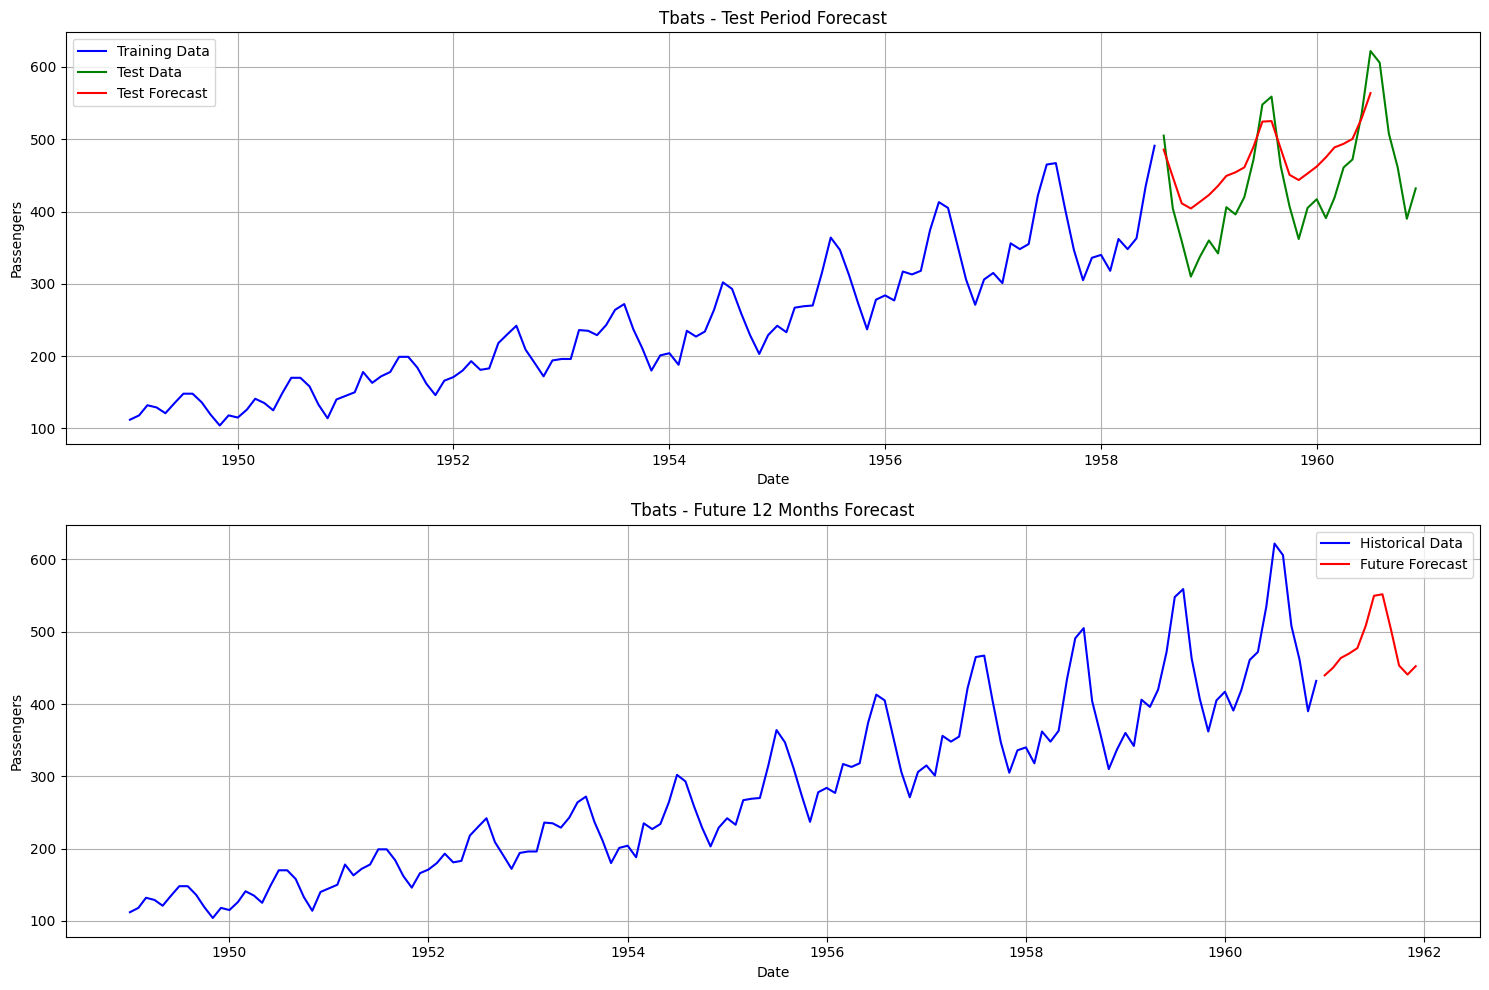


--------------------------------------------------
Testing prophet...
--------------------------------------------------
Fitting prophet on training data...
Fitting prophet forecaster with expanding cross-validation...
Fitting 4 folds for each of 32 candidates, totalling 128 fits


/home/yaeg/Documents/projects/packages/Adaptive_forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/model_selection/_tune.py:90: UserWarning: Parameter n_jobs of ForecastingGridSearchCV has been removed in sktime 0.27.0 and is no longer used. It is ignored when passed. Instead, the backend and backend_params parameters should be used to pass n_jobs or other parallelization parameters.
  warn(
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plot

Generating test predictions for prophet...
Making predictions...
Test Predictions: 1958-08    495.456724
1958-09    428.164433
1958-10    370.732044
1958-11    322.432836
1958-12    362.822300
1959-01    370.392115
1959-02    347.396442
1959-03    398.275375
1959-04    391.930181
1959-05    404.969664
1959-06    484.721526
1959-07    543.326771
1959-08    537.388841
1959-09    461.231088
1959-10    400.481438
1959-11    345.758720
1959-12    391.149634
1960-01    401.202129
1960-02    374.862384
1960-03    434.934929
1960-04    423.422847
1960-05    438.370798
1960-06    520.755867
1960-07    579.206083
Freq: M, Name: Number of airline passengers, dtype: float64
Evaluating prophet on test set...

Test Performance Metrics:
------------------------------
RMSE: 18.8926
MAPE: 0.0365
MAE: 15.8253
MSE: 356.9297
Refitting prophet on full dataset and generating future predictions...
Refitting prophet on full dataset with best parameters...


20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:19 - cmdstanpy - INFO - Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1] done processing


Generating future predictions for 12 periods...
Making predictions...
Test Predictions: 1958-08    495.456724
1958-09    428.164433
1958-10    370.732044
1958-11    322.432836
1958-12    362.822300
1959-01    370.392115
1959-02    347.396442
1959-03    398.275375
1959-04    391.930181
1959-05    404.969664
1959-06    484.721526
1959-07    543.326771
1959-08    537.388841
1959-09    461.231088
1959-10    400.481438
1959-11    345.758720
1959-12    391.149634
1960-01    401.202129
1960-02    374.862384
1960-03    434.934929
1960-04    423.422847
1960-05    438.370798
1960-06    520.755867
1960-07    579.206083
Freq: M, Name: Number of airline passengers, dtype: float64


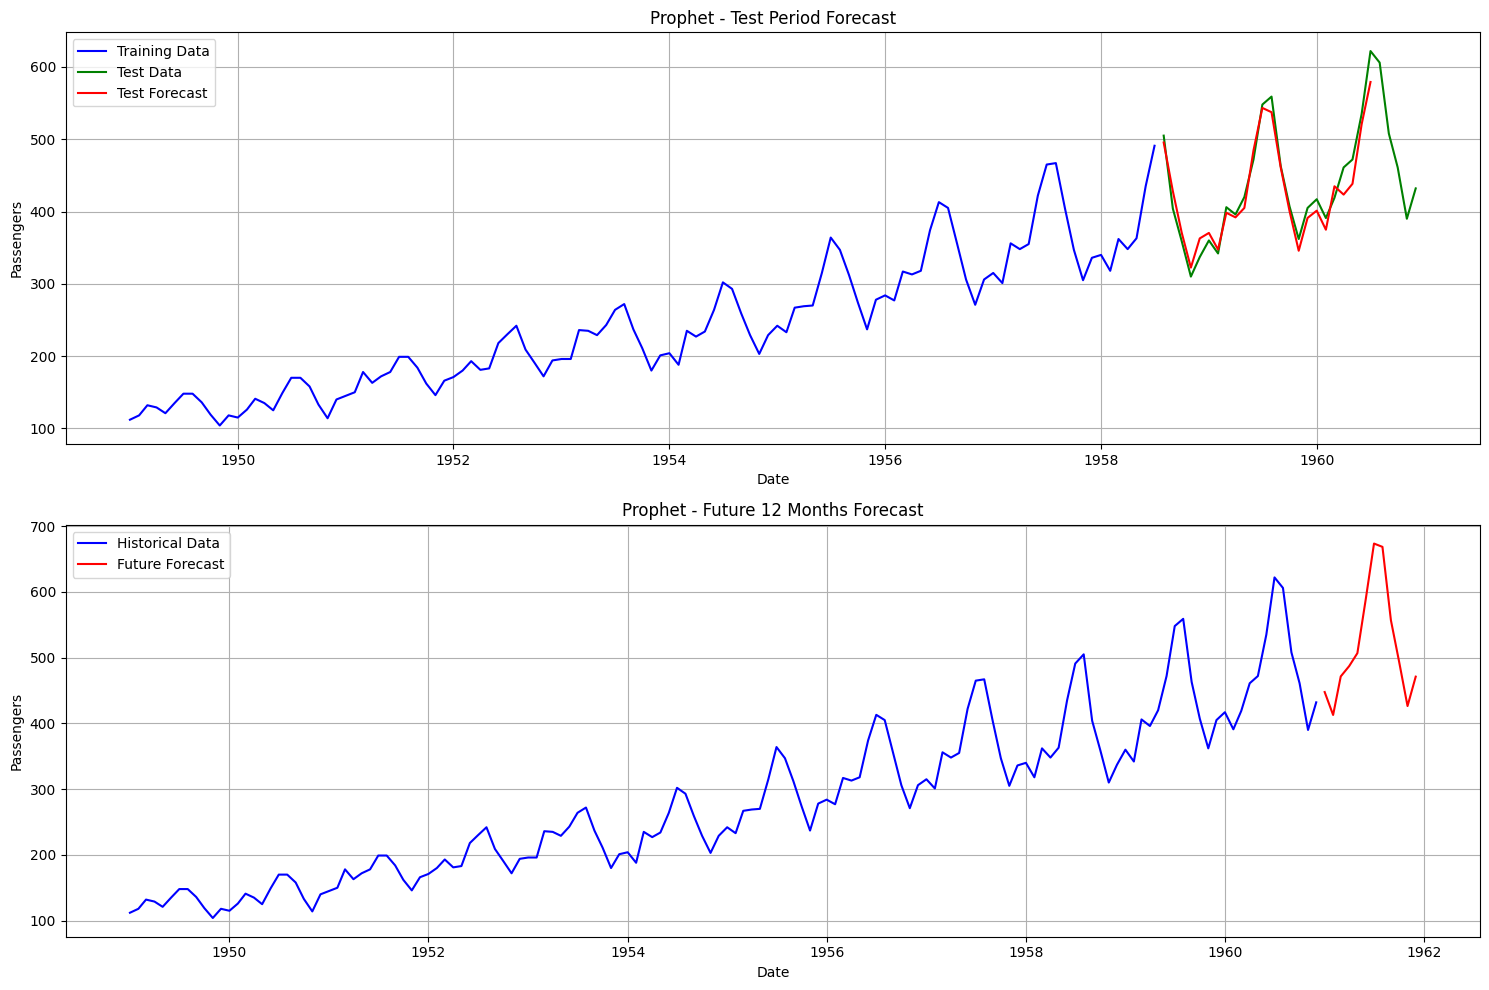


=== Algorithm Comparison ===
                    RMSE      MAPE        MAE
Algorithm                                    
naive          46.667008  0.072368  34.025865
stats_arima    53.033778  0.088410  39.184963
exp_smoothing  35.018152  0.062558  28.666188
ets            49.989915  0.111946  44.501778
tbats          54.789053  0.124608  49.210136
prophet        18.892582  0.036511  15.825337

=== Best Algorithm per Metric ===
Best for RMSE: prophet (18.8926)
Best for MAPE: prophet (0.0365)
Best for MAE: prophet (15.8253)
Best for MSE: prophet (356.9297)


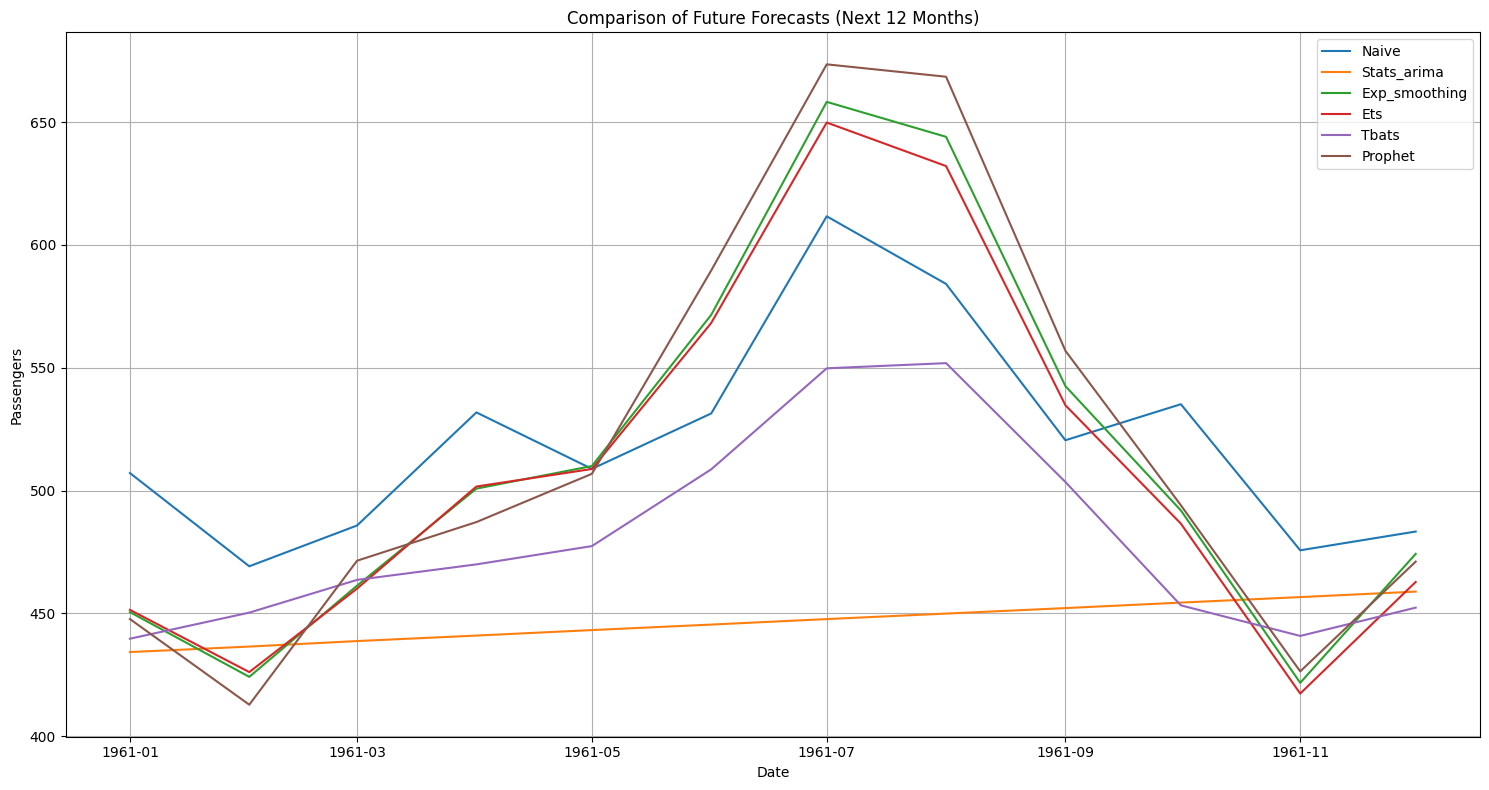


=== Summary ===
Total models evaluated: 6
Best algorithm by RMSE: prophet
All results stored in memory


In [56]:
"""
Example using AdaptiveForecaster with the new refit_on_full_data method
"""
import warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sktime.datasets import load_airline

#from forecaster import AdaptiveForecaster

# First, add the refit_on_full_data method to the AdaptiveForecaster class
# This should be done in the actual class file, but for this example
# we're monkey-patching it
#AdaptiveForecaster.refit_on_full_data = refit_on_full_data

# Load the airline passengers dataset
print("Loading airline passengers dataset...")
y = load_airline()

# Split data into train and test sets (last 24 months as test)
train_size = len(y) - 24
train, test = y.iloc[:train_size], y.iloc[train_size:]
print(f"Training set: {len(train)} observations ({train.index.min()} - {train.index.max()})")
print(f"Test set: {len(test)} observations ({test.index.min()} - {test.index.max()})")

# In-memory storage for results
results_storage = {
    "models": {},
    "test_predictions": {},
    "future_predictions": {}
}

# List of algorithms to compare
algorithms = ['naive','stats_arima', 'exp_smoothing','ets','tbats','prophet']
model_results = {}
comparison_data = []

for algo in algorithms:
    print(f"\n{'-'*50}")
    print(f"Testing {algo}...")
    print(f"{'-'*50}")
    
    try:
        # Create and fit forecaster on training data
        algo_forecaster = AdaptiveForecaster(
            algorithm=algo,
            seasonal_period=12,
            fh=len(test),
            cv_strategy='expanding',
            cv_initial_window=80,
            cv_step_length=3,
            metric='mape',
            n_jobs=1,
            verbose=1
        )
        
        # Split, fit, predict
        train_y, test_y = algo_forecaster.split_data(y)
        print(f"Fitting {algo} on training data...")
        algo_forecaster.fit(train_y)
        
        # Generate predictions for test period
        print(f"Generating test predictions for {algo}...")
        test_predictions = algo_forecaster.predict(fh=list(range(1, len(test) + 1)))
        print("Test Predictions:", test_predictions)
        # Evaluate with multiple metrics
        print(f"Evaluating {algo} on test set...")
        test_metrics = algo_forecaster.evaluate(metrics=['rmse', 'mape', 'mae', 'mse'])
        
        # Now use the new method to refit on full data and get future predictions
        print(f"Refitting {algo} on full dataset and generating future predictions...")
        future_horizon = 12
        future_predictions = algo_forecaster.forecast_future(y, future_horizon=future_horizon)
        
        # Store results
        result_id = f"{algo}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Store in the dictionaries
        results_storage["models"][result_id] = {
            "id": result_id,
            "algorithm": algo,
            "timestamp": datetime.now().isoformat(),
            "metrics": test_metrics,
            "best_params": algo_forecaster.best_params,
            "cv_score": float(algo_forecaster.best_score),
            "forecaster": algo_forecaster.grid_search.best_forecaster_
        }
        
        results_storage["test_predictions"][result_id] = test_predictions
        results_storage["future_predictions"][result_id] = future_predictions
        
        # Store in model_results for easier reference
        model_results[algo] = {
            "result_id": result_id,
            "forecaster": algo_forecaster,
            "test_predictions": test_predictions,
            "future_predictions": future_predictions,
            "metrics": test_metrics
        }
        
        # Add to comparison data
        comparison_data.append({
            'Algorithm': algo,
            'Result ID': result_id,
            'RMSE': test_metrics['rmse'],
            'MAPE': test_metrics['mape'],
            'MAE': test_metrics['mae'],
            'MSE': test_metrics['mse']
        })
        
        print("Test Predictions:", test_predictions)
        # Create visualization
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Test period
        plt.subplot(2, 1, 1)
        plt.plot(train_y.index.to_timestamp(), train_y, 'b-', label='Training Data')
        plt.plot(test_y.index.to_timestamp(), test_y, 'g-', label='Test Data')
        plt.plot(test_predictions.index.to_timestamp(), test_predictions, 'r-', label=f'Test Forecast')
        plt.title(f'{algo.capitalize()} - Test Period Forecast')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Future predictions
        plt.subplot(2, 1, 2)
        plt.plot(y.index.to_timestamp(), y, 'b-', label='Historical Data')
        plt.plot(future_predictions.index.to_timestamp(), future_predictions, 'r-', label=f'Future Forecast')
        plt.title(f'{algo.capitalize()} - Future {future_horizon} Months Forecast')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error with {algo}: {e}")
        import traceback
        traceback.print_exc()

# Create comparison table
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n=== Algorithm Comparison ===")
    print(comparison_df[['Algorithm', 'RMSE', 'MAPE', 'MAE']].set_index('Algorithm'))
    
    # Find best algorithm for each metric
    print("\n=== Best Algorithm per Metric ===")
    metrics = ['RMSE', 'MAPE', 'MAE', 'MSE']
    best_algorithms = {}
    
    for metric in metrics:
        best_algo_idx = comparison_df[metric].idxmin()
        best_algo = comparison_df.loc[best_algo_idx]
        best_algorithms[metric] = best_algo['Algorithm']
        print(f"Best for {metric}: {best_algo['Algorithm']} ({best_algo[metric]:.4f})")

# Create final comparison plot of future predictions
plt.figure(figsize=(15, 8))
for algo in model_results:
    future_pred = model_results[algo]["future_predictions"]
    plt.plot(future_pred.index.to_timestamp(), future_pred, '-', label=f'{algo.capitalize()}')

plt.title('Comparison of Future Forecasts (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


if comparison_data:
    best_metric = 'RMSE'  # Choose your preferred metric
    best_algo_name = best_algorithms[best_metric]
    best_result = model_results[best_algo_name]
    """
    print(f"\n=== Logging Best Model ({best_algo_name}) to MLflow ===")
    log_to_mlflow_sktime(
        forecaster=best_result["forecaster"],
        result_id=best_result["result_id"],
        metrics=best_result["metrics"]
    )
    """

print("\n=== Summary ===")
print(f"Total models evaluated: {len(results_storage['models'])}")
print(f"Best algorithm by RMSE: {best_algorithms.get('RMSE', 'N/A')}")
print(f"All results stored in memory")

In [36]:
#results_storage['test_predictions']
results_storage['future_predictions']

{'naive_20250311_195726': 1961-01    434.237762
 1961-02    436.475524
 1961-03    438.713287
 1961-04    440.951049
 1961-05    443.188811
 1961-06    445.426573
 1961-07    447.664336
 1961-08    449.902098
 1961-09    452.139860
 1961-10    454.377622
 1961-11    456.615385
 1961-12    458.853147
 Freq: M, Name: Number of airline passengers, dtype: float64,
 'stats_arima_20250311_195916': 1961-01    462.643741
 1961-02    492.150462
 1961-03    522.320688
 1961-04    545.543306
 1961-05    557.307858
 1961-06    556.946973
 1961-07    547.211519
 1961-08    532.978982
 1961-09    519.584896
 1961-10    511.292748
 1961-11    510.298523
 1961-12    516.457385
 Freq: M, Name: Number of airline passengers, dtype: float64,
 'exp_smoothing_20250311_200219': 1961-01    433.864374
 1961-02    435.926623
 1961-03    437.988872
 1961-04    440.051121
 1961-05    442.113370
 1961-06    444.175619
 1961-07    446.237868
 1961-08    448.300117
 1961-09    450.362366
 1961-10    452.424616
 1961

naive_20250311_195726
stats_arima_20250311_195916
exp_smoothing_20250311_200219


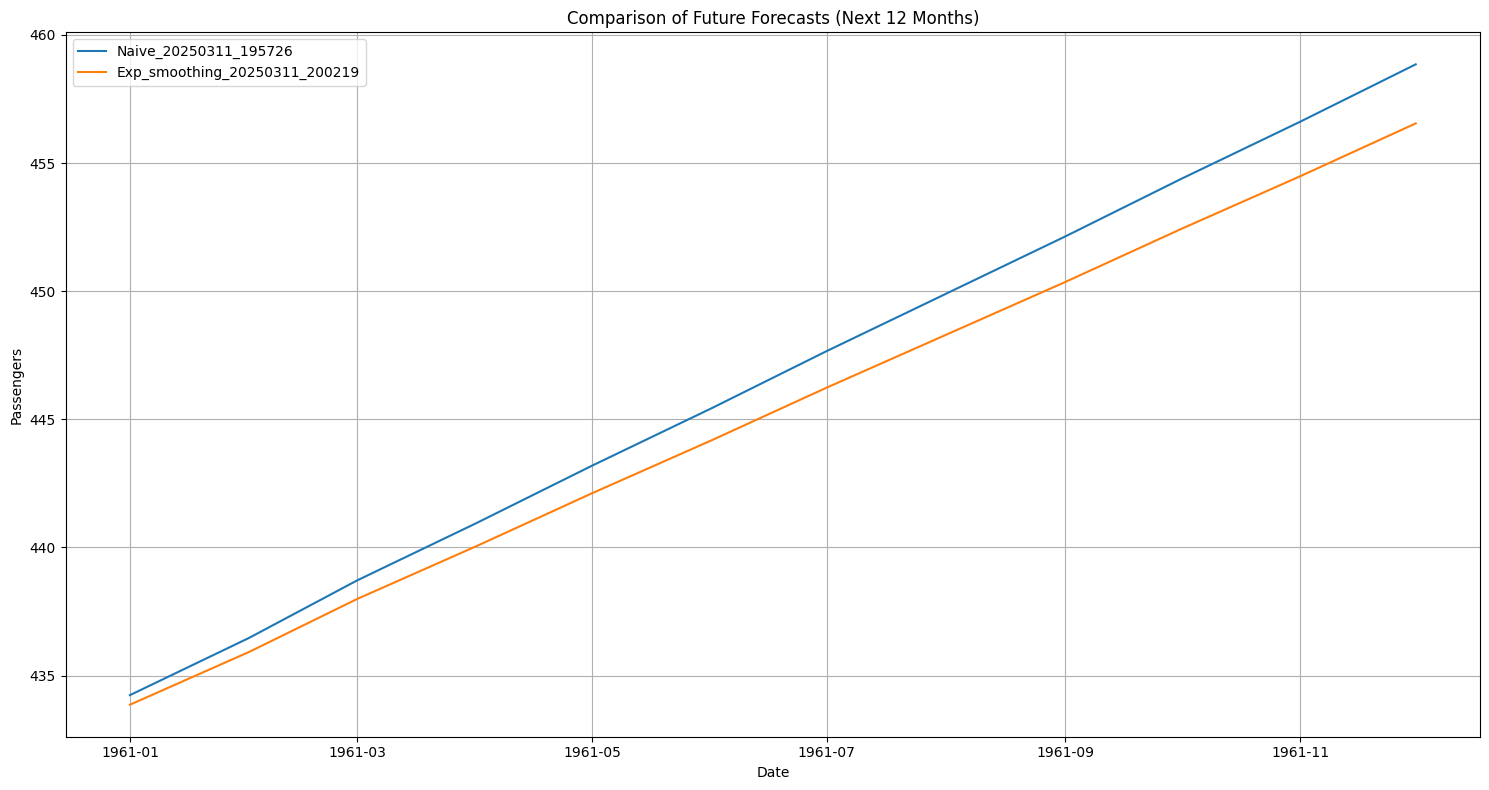

In [41]:
plt.figure(figsize=(15, 8))
for algo in results_storage['future_predictions']:
    print(algo)
    future_pred = results_storage["future_predictions"][algo]
    # Convert Period index to datetime for plotting
    if 'naive' in algo or 'exp' in algo:
        plt.plot(future_pred.index.to_timestamp(), future_pred, '-', label=f'{algo.capitalize()}')
    # Alternative: plt.plot(pd.to_datetime(future_pred.index.astype(str)), future_pred, '-', label=f'{algo.capitalize()}')

# ... existing code ...
plt.title('Comparison of Future Forecasts (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()